## Generate plots from TEMPO/TROPOMI H(x) IODA files
This notebook will generate horizontal distribution for TEMPO/TROPOMI over the user-defined area.

In [1]:
import os
import numpy as np
import xarray as xr
import matplotlib as mpl
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cft
from functions import set_size, get_dates

### Setup the script running period, features of figure

In [2]:
tlsize = 12
txsize = 12
mpl.rc('axes', titlesize=tlsize, labelsize=txsize)
mpl.rc('xtick', labelsize=txsize)
mpl.rc('ytick', labelsize=txsize)
mpl.rc('legend', fontsize='small')

# Figure size setup
axe_w = 4
axe_h = 4
plot_quality = 600
# Colorbar control
cb_ori = 'vertical'
cb_frac = 0.025
cb_pad = 0.04
cb_asp = 32
# Area control
projection_like = 'wxaq'
minlon = -81.
maxlon = -70
minlat = 39.8
maxlat = 46.
plotqc = -1

srcpath = '/glade/work/swei/Git/JEDI-METplus'
plot_product = 'wrfchem_evaluate'

# Setup observation name
obs_name = 'tropomi_s5p_no2_troposphere-wxaq'
dotsize = 5
# obs_name = 'tempo_no2_tropo-wxaq'
# dotsize = 1.5

# JEDI variable name, var:channel 
plot_var = 'nitrogendioxideColumn'
# units_str = 'mol m$^{-2}$'
units_str = '10$^{15}$ molec cm$^{-2}$'
# Level control
vmin = 0
vmax = 10

vrfy_fhr = 19
sdate = 2024082419
edate = 2024082419
hint = 24
dates = get_dates(sdate, edate, hint)

### Setup default variable name, units, paths, and Cartopy projection

In [3]:
if 'tropomi' in obs_name:
    sensor = 'TROPOMI'
elif 'tempo' in obs_name:
    sensor = 'TEMPO'

varstr_dict = {
    'nitrogendioxideColumn': 'Tropospheric NO$_{2}$',
    'nitrogendioxideTotal': 'Total NO$_{2}$',
    'carbonmonoxideTotal': 'Total CO',
}

units_factors_dict = {
    'mol m$^{-2}$': 1.,
    '10$^{15}$ molec cm$^{-2}$': 6.022e4,
}

hofx_path = os.path.join(srcpath, 'output', plot_product, 'hofx',
                         'f%.2i' % (vrfy_fhr), obs_name)
plts_path = os.path.join(srcpath, 'output', plot_product, 'plots', '2dmap', obs_name)

if not os.path.exists(hofx_path):
    raise Exception(f'HofX folder: {hofx_path} is not available')

if not os.path.exists(plts_path):
    os.makedirs(plts_path)

# Setup projection
if projection_like == 'wxaq':
    proj = ccrs.LambertConformal(central_longitude=-97.0,
                                 central_latitude=39.0,
                                 standard_parallels=[30., 60.])
if projection_like == 'glb':
    proj = ccrs.PlateCarree()

### Loop through cycles to create scatter plot of ObsValue and H(x) for each cycle

Processing: hofx.tropomi_s5p_no2_troposphere-wxaq.2024082419.nc4
/glade/work/swei/Git/JEDI-METplus/output/wrfchem_evaluate/plots/2dmap/tropomi_s5p_no2_troposphere-wxaq/ObsValue_nitrogendioxideColumn.f19.2024082419.png
/glade/work/swei/Git/JEDI-METplus/output/wrfchem_evaluate/plots/2dmap/tropomi_s5p_no2_troposphere-wxaq/hofx_nitrogendioxideColumn.f19.2024082419.png
Process Finished


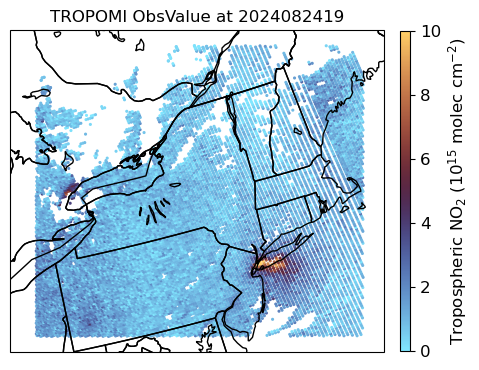

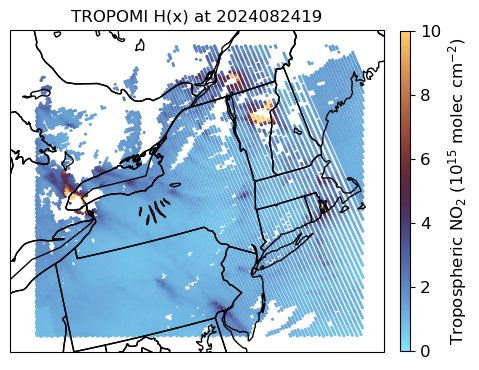

In [4]:
for cdate in dates:
    plot_date = cdate.strftime('%Y%m%d%H')
    hofx_file = f'hofx.{obs_name}.{plot_date}.nc4'
    print(f'Processing: {hofx_file}')
    in_hofx = os.path.join(hofx_path, hofx_file)
    if not os.path.exists(in_hofx):
        print(f'WARNING: Skip {plot_date}, {hofx_file} is not available')
        continue

    meta_ds = xr.open_dataset(in_hofx, group='MetaData')
    lons = meta_ds.longitude
    lats = meta_ds.latitude

    obsval_ds = xr.open_dataset(in_hofx, group='ObsValue')
    hofx_ds = xr.open_dataset(in_hofx, group='hofx')
    preqc_ds = xr.open_dataset(in_hofx, group='PreQC')

    varname = plot_var
    obsval = obsval_ds[varname]
    hofx = hofx_ds[varname]
    qc = preqc_ds[varname]
    varstr = varstr_dict[varname]

    if plotqc != -1:
        pltmsk = qc == plotqc
    else:
        pltmsk = ~np.isnan(lons)
    cnts = np.count_nonzero(pltmsk)

    for plot_type in ['ObsValue', 'H(x)']:
        if plot_type == 'ObsValue':
            pltdata = obsval
            filetag = plot_type
        if plot_type == 'H(x)':
            pltdata = hofx
            filetag = 'hofx'
        pltdata = pltdata * units_factors_dict[units_str]

        fig = plt.figure()
        ax = plt.subplot(projection=proj)
        set_size(axe_w, axe_h, t=0.96, l=0.04, b=0.04, r=0.86)
        ax.set_extent((minlon, maxlon, minlat, maxlat), crs=ccrs.PlateCarree())
        gl = ax.gridlines(draw_labels=False, dms=True, x_inline=False, y_inline=False)
        gl.xlines = False
        gl.ylines = False
        gl.xlabel_style = {'size': txsize - 1}
        gl.ylabel_style = {'size': txsize - 1}
        gl.right_labels = False
        gl.top_labels = False
        sc = ax.scatter(lons[pltmsk], lats[pltmsk], c=pltdata[pltmsk], s=dotsize,
                        vmin=vmin, vmax=vmax, transform=ccrs.PlateCarree(),
                        cmap='managua_r', edgecolors='None')

        ax.add_feature(cft.BORDERS.with_scale('50m'), zorder=4)
        if projection_like == 'glb':
            ax.coastlines(resolution='50m')
        if projection_like == 'wxaq':
            ax.add_feature(cft.STATES.with_scale('50m'), zorder=4)
            ax.add_feature(cft.LAKES.with_scale('50m'), facecolor='None',
                           edgecolor='k', zorder=4)

        title_str = f'{sensor} {plot_type} at {plot_date}'
        cb_str = f'{varstr} ({units_str})'
        ax.set_title(title_str, loc='center')
        cb = plt.colorbar(sc, orientation=cb_ori, fraction=cb_frac, pad=cb_pad, aspect=cb_asp, label=cb_str)
        cb.set_label(cb_str, fontsize=txsize)

        # If use 'mol m$^{-2}$' as units, uncomment the line below for colorbar in scientific notation.
        # cb.ax.ticklabel_format(axis='y', style='sci', scilimits=(0, 0), useMathText=True)
        
        plotname = f'{filetag}_{varname}.f{vrfy_fhr}.{plot_date}.png'
        outname = os.path.join(plts_path, plotname)
        fig.savefig(outname, dpi=plot_quality)
            
        print(outname)

print('Process Finished')